<a href="https://colab.research.google.com/github/Darshak910/NLP/blob/master/NLP_A02_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Installing pytorch-ignite
!pip install pytorch-ignite

In [0]:
# Importing all the required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer

import torch
from torch.nn import Conv1d, MaxPool1d, Flatten, Linear
from torch.nn import L1Loss, CrossEntropyLoss, Dropout
from torch.nn.functional import relu, softmax, sigmoid
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD, Adam, SparseAdam, Adamax
from ignite.metrics import Accuracy, Recall, Precision

In [4]:
# Reading the dataset and saving to pandas dataframe
ds = pd.read_csv('https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv',
                 delimiter='\t')
ds.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [5]:
# Saving only the two required columns
ds = ds[['Phrase', 'Sentiment']]
ds.head(10)

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2
5,of escapades demonstrating the adage that what...,2
6,of,2
7,escapades demonstrating the adage that what is...,2
8,escapades,2
9,demonstrating the adage that what is good for ...,2


In [6]:
ds['Phrase'][1]

'A series of escapades demonstrating the adage that what is good for the goose'

In [7]:
# Downloading the stopwords and wordnet corpus
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
porter_stemmer = PorterStemmer()
lancaster_stemmer = LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_en = stopwords.words("english")
punctuations = "?:!.,;'\"-()/\\{}[]|"

# Parameters to adjust to see the impact on outcome
remove_stopwords = True
use_stemming = True
use_lemmatization = False
remove_punctuations = True

In [9]:
len(ds)

156060

In [10]:
# Split the dataset with 70% for Training set and 30% for Testing set
# Shuffling the dataset with random state set to 2003
x_train, x_test, y_train, y_test = train_test_split(
    ds['Phrase'], ds['Sentiment'], test_size=0.3,
    shuffle='True', random_state=2003)

train_ds = pd.DataFrame(list(zip(x_train, y_train)), columns=['Phrase', 'Sentiment'])
test_ds = pd.DataFrame(list(zip(x_test, y_test)), columns=['Phrase', 'Sentiment'])

print(test_ds['Phrase'])

0                                         veteran
1                                many definitions
2                            a worthwhile glimpse
3                               past Seagal films
4                                    banal script
                           ...                   
46813                                the very end
46814    self-consciously flashy camera effects ,
46815                        a half-hearted fluke
46816                       's certainly laudable
46817                                 human drama
Name: Phrase, Length: 46818, dtype: object


In [0]:
# Pre-processing for the Training set
X, Y = [], []

# For every single label save the Sentiment label
for y in range(len(train_ds)):
  label = train_ds['Sentiment'][y]
  temp_phrase = []

  # Split the phrase to words and setting the text to lowercase
  space = str(train_ds['Phrase'][y]).lower().split(' ')
  # print(space)

  # For each word in the Phrase
  for word in space:
    new_word = word

    # Giving conditional procedures according to stopwords and punctuations
    if(word in stopwords_en):
      continue
    if(word in punctuations):
      continue
    
    # Condition specifying if stemming is used or not
    if(use_stemming):
      # Using either Porter or Lancaster stemming
      new_word = porter_stemmer.stem(new_word)
      # new_word = lancaster_stemmer.stem(new_word)
    
    # Condition specifying if lemmatization is used or not
    if(use_lemmatization):
      new_word = wordnet_lemmatizer.lemmatize(new_word)

    # Adding normalized word to a temporary variable
    temp_phrase.append(new_word)

  # if(not temp_phrase == []):
  X.append(temp_phrase)
  Y.append(label)

In [12]:
len(X)

109242

In [0]:
# Joining the phrase
for i in range(len(X)):
  X[i] = ' '.join(X[i])

In [14]:
X[2]

'fan gross-out comedi'

In [15]:
len(X)

109242

In [16]:
# Merging two lists into a tuple using zip() method and converting the lists of
# tuples to Pandas DataFrame and setting the column name
ds_train = pd.DataFrame(list(zip(X, Y)), columns=['Phrase', 'Sentiment'])

# Replacing the blank cells with NaN in the DataFrame
ds_train['Phrase'].replace('', np.nan, inplace=True)

# Dropping all the NaN values from the DataFrame
ds_train.dropna(subset=['Phrase'], inplace=True)

len(ds_train)

108578

In [17]:
ds_train

,Phrase,Sentiment
0,age,2
1,gorgeou epic,4
2,fan gross-out comedi,2
3,filmmak ascend liter olympu art world,4
4,twist mysteri,2
...,...,...
109237,dull sens faster deeper recreat drug market,1
109238,bitter less matur,1
109239,play better film 's publicist peopl take mani ...,1
109240,faith,2


In [18]:
# Phrases associated to sentiment labels count
print(ds_train.Sentiment.value_counts())

2    54977
3    23021
1    19191
4     6468
0     4921
Name: Sentiment, dtype: int64


In [19]:
# Manually counting the number of '0' labelled sentiments
count = 0
for y in ds_train['Sentiment']:
  if(y == 0):
    count+=1
print(count)

4921


In [0]:
# Saving similar labelled phrases together for resampling
y0 = ds_train[ds_train['Sentiment'] == 0]
y1 = ds_train[ds_train['Sentiment'] == 1]
y2 = ds_train[ds_train['Sentiment'] == 2]
y3 = ds_train[ds_train['Sentiment'] == 3]
y4 = ds_train[ds_train['Sentiment'] == 4]

In [0]:
# Randomly down sampling each label to match the count of the lowest label count
y00 = resample(y0, replace = True, n_samples = count, random_state = 2003)
y01 = resample(y1, replace = True, n_samples = count, random_state = 2003)
y02 = resample(y2, replace = True, n_samples = count, random_state = 2003)
y03 = resample(y3, replace = True, n_samples = count, random_state = 2003)
y04 = resample(y4, replace = True, n_samples = count, random_state = 2003)

In [22]:
# Concatinating the new down sampled dataset
ds_train = pd.concat([y00, y01, y02, y03, y04])

# ds_train.Sentiment.value_counts()
ds_train.shape

(24605, 2)

In [0]:
# Transforming each text into vector of word counts using CountVectorizer
vectorizer = CountVectorizer(max_features=20000, stop_words="english",
                             ngram_range=(1, 2))

# Transforming each text into vector of word counts using TfidfVectorizer
# vectorizer = TfidfVectorizer(max_features=20000, stop_words="english",
#                              ngram_range=(2, 2))

x_train = vectorizer.fit_transform(ds_train["Phrase"])
y_train = ds_train["Sentiment"]

In [24]:
x_train.shape
# x_test.shape
# X.shape[1]
# y_train.shape

(24605, 20000)

In [25]:
# Converting into numpy arrays
x_train_np = x_train.toarray()
y_train_np = np.array(y_train)

print(x_train_np.shape)

(24605, 20000)


In [0]:
# Creating a class to define our model
class CNNMultipleClassifier(torch.nn.Module):
  # The initialization method
  def __init__(self, batchsize, inputs, outputs):
    super(CNNMultipleClassifier, self).__init__()
    self.batchsize = batchsize
    self.inputs = inputs
    self.outputs = outputs

    # Defining the input layer (input channels, output channels, kernels)
    self.input_layer = Conv1d(inputs, batchsize, 1)

    # Maxpooling layer with kernel size
    self.maxpooling_layer = MaxPool1d(1)

    # Adding Conv1d layers
    self.conv_layer1 = Conv1d(batchsize, 64, 1)
    self.conv_layer2 = Conv1d(64, 128, 1)

    # A Flatten layer
    self.flatten_layer = Flatten()

    # A Linear layer with (inputs, outputs)
    self.linear_layer1 = Linear(128, 64)
    # Adding a dropout layer for reducing overfitting
    self.dropout_layer = Dropout(p=0.2)

    # Lastly, an Output layer
    self.output_layer = Linear(64, outputs)

  # A method to feed the model
  def feed(self, input):
    # Reshape so that it can be fed to input layer
    # Although 1D Conv, it expects a 3D array in 1D fashion
    input = input.reshape((self.batchsize, self.inputs, 1))

    # Run through the Relu
    output = relu(self.input_layer(input))

    # Get the output of MaxPooling
    output = self.maxpooling_layer(output)

    # Output of Conv1d layers and passing through Relu
    output = relu(self.conv_layer1(output))
    output = relu(self.conv_layer2(output))

    # Output of flatten layer
    output = self.flatten_layer(output)

    # Output of Linear layer and pass through Relu
    output = relu(self.linear_layer1(output))
    # Output of Dropout layer
    output = self.dropout_layer(output)

    # Lastly, output of Output layer
    output = self.output_layer(output)

    # Get value between 0 and 1 using Sigmoid
    # output = sigmoid(output)

    # To get accuracy we get int values of 0 or 1
    output_ = torch.round(output)

    # Using Softmax
    output = softmax(output)

    return output, output_

In [27]:
# Defining our model
batchsize = 128

# (batchsize, x_columns, y_columns)
model = CNNMultipleClassifier(batchsize, x_train.shape[1], 5)

# Set the model to use GPU
model.cuda()

CNNMultipleClassifier(
  (input_layer): Conv1d(20000, 128, kernel_size=(1,), stride=(1,))
  (maxpooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
  (conv_layer2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer1): Linear(in_features=128, out_features=64, bias=True)
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=64, out_features=5, bias=True)
)

In [0]:
# Method to return L1Loss, Accuracy, Recall and Precision
def model_loss(model, dataset, train = False, optimizer = None):
  
  # Using crossentropy loss for calculating the loss
  cross_loss = CrossEntropyLoss()

  avg_loss = 0
  avg_accuracy = 0
  avg_recall = 0
  avg_precision = 0
  count = 0

  for input, output in iter(dataset):
    # Get predictions for training dataset
    predictions, predictions_ = model.feed(input)
    # print(predictions)

    # Converting to numpy
    a = []
    out = output.data.cpu().numpy()
    for o in out:
      a.append(int(o[0]))

    # Taking out the max valued labels
    pred, indices = torch.max(predictions, 1)

    # Converting to long tensor type 
    a_list = torch.FloatTensor(a).cuda().long()

    # Get the Loss
    loss = cross_loss(predictions, a_list)

    # Other metric performances using softmax returned output
    accuracy = accuracy_score(a, indices.data.cpu())
    recall = recall_score(a, indices.data.cpu(), average='macro', zero_division=0)
    precision = precision_score(a, indices.data.cpu(), average='macro', zero_division=0)

    if(train):
      # Clear errors
      optimizer.zero_grad()
      # Compute the gradients for our optimizer
      loss.backward()
      # Using optimizer to update model's parameters based on gradients
      optimizer.step()
    
    # Loss
    avg_loss += loss.item()

    # Other performance metrics
    avg_accuracy += accuracy
    avg_recall += recall
    avg_precision += precision
    count += 1
  
  return avg_loss/count, avg_accuracy/count, avg_recall/count, avg_precision/count

In [29]:
epoch_history = []
f1_score_history = []
loss_history = []
accuracy_history = []

# Training the model
epochs = 50
# optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9)
optimizer = Adam(model.parameters(), lr=1e-3)
# optimizer = Adamax(model.parameters(), lr=1e-3)

# Convert training set to torch variables using GPU as float.
# The reshape is to remove PyTorch warning
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()

# Create DataLoader instance to work with batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batchsize, shuffle=True, drop_last=True)

# Start training loop
for epoch in range(epochs):
  # Cycle through batches and get average loss and other metrics
  avg_loss, avg_accuracy, avg_recall, avg_precision = model_loss(model, loader, train=True, optimizer=optimizer)
  
  # Get f1 score
  f1 = (2 * (avg_precision * avg_recall)/(avg_precision + avg_recall))

  # Saving the history for ploting on graph
  epoch_history.append(epoch + 1)
  f1_score_history.append(f1)
  loss_history.append(avg_loss)
  accuracy_history.append(avg_accuracy)

  # Printing the loss and other metrics
  print("Epoch " + str(epoch + 1) + 
        ":\n\tLoss = " + str(avg_loss) +
        "\n\tAccuracy = " + str(avg_accuracy) +
        "\n\tRecall = " + str(avg_recall) +
        "\n\tPrecision = " + str(avg_precision) +
        "\n\tF1 Score = " + str(f1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1:
	Loss = 1.4750205775101979
	Accuracy = 0.3989664713541667
	Recall = 0.39958640235859083
	Precision = 0.32674051224008976
	F1 Score = 0.3595104715703943
Epoch 2:
	Loss = 1.339122548699379
	Accuracy = 0.5596923828125
	Recall = 0.5598586754161601
	Precision = 0.5577843285503955
	F1 Score = 0.5588195769880403
Epoch 3:
	Loss = 1.2728646211326122
	Accuracy = 0.6290283203125
	Recall = 0.6288463927360441
	Precision = 0.6346447731321562
	F1 Score = 0.6317322780467665
Epoch 4:
	Loss = 1.230479013795654
	Accuracy = 0.6722412109375
	Recall = 0.6720050094261185
	Precision = 0.6765285901995611
	F1 Score = 0.6742592127630921
Epoch 5:
	Loss = 1.2069270604600508
	Accuracy = 0.6964925130208334
	Recall = 0.696721898515705
	Precision = 0.6996655194984922
	F1 Score = 0.6981906063923161
Epoch 6:
	Loss = 1.1921152354528506
	Accuracy = 0.71142578125
	Recall = 0.7123660673164195
	Precision = 0.7139975615830035
	F1 Score = 0.7131808813869609
Epoch 7:
	Loss = 1.1843682192265987
	Accuracy = 0.71923828125

In [30]:
# Saving model
torch.save(model, '1101352_1dconv_reg.pt') 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNNMultipleClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [31]:
# Loading model
model = torch.load('1101352_1dconv_reg.pt')
model.eval()

CNNMultipleClassifier(
  (input_layer): Conv1d(20000, 128, kernel_size=(1,), stride=(1,))
  (maxpooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
  (conv_layer2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer1): Linear(in_features=128, out_features=64, bias=True)
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=64, out_features=5, bias=True)
)

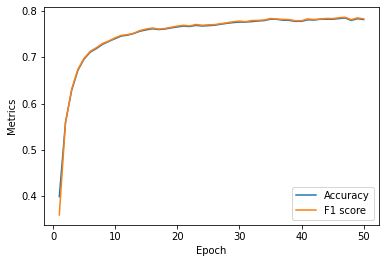

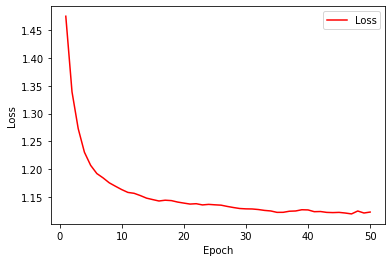

In [32]:
# Plotting Accuracy and F1 score together
plt.plot(epoch_history, accuracy_history, label='Accuracy')
plt.plot(epoch_history, f1_score_history, label='F1 score')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.show()

# Graph for Loss w.r.t Epoch
plt.plot(epoch_history, loss_history, label='Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
# Pre-processing for the Testing set
X, Y = [], []

# For every single label save the Sentiment label
for y in range(len(test_ds)):
  label = test_ds['Sentiment'][y]
  temp_phrase = []

  # Splitting the pharase to words and setting the text to lowercase
  space = str(test_ds['Phrase'][y]).lower().split(' ')
  # print(space)

  # For each word in the Phrase
  for word in space:
    new_word = word

    # Giving conditional procedures according to stopwords and punctuations
    if(word in stopwords_en):
      continue
    if(word in punctuations):
      continue
    
    # Condition specifying if stemming is used or not
    if(use_stemming):
      # Using either Porter or Lancaster stemming
      new_word = porter_stemmer.stem(new_word)
      # new_word = lancaster_stemmer.stem(new_word)
    
    # Condition specifying if lemmatization is used or not
    if(use_lemmatization):
      new_word = wordnet_lemmatizer.lemmatize(new_word)

    # Adding normalized word to a temporary variable
    temp_phrase.append(new_word)

  # if(not temp_phrase == []):
  X.append(temp_phrase)
  Y.append(label)

In [34]:
len(X)

46818

In [0]:
# Joining the phrase
for i in range(len(X)):
  X[i] = ' '.join(X[i])

In [36]:
X[2]

'worthwhil glimps'

In [37]:
len(X)

46818

In [38]:
# Merging two lists into a tuple using zip() method and converting the lists of
# tuples to Pandas DataFrame and setting the column name
ds_test = pd.DataFrame(list(zip(X, Y)), columns=['Phrase', 'Sentiment'])

# Replacing the blank cells with NaN in the DataFrame
ds_test['Phrase'].replace('', np.nan, inplace=True)

# Dropping all the NaN values from the DataFrame
ds_test.dropna(subset=['Phrase'], inplace=True)

# ds_test.head()
len(ds_test)

46540

In [39]:
print(ds_test.Sentiment.value_counts())

2    23730
3     9859
1     8062
4     2738
0     2151
Name: Sentiment, dtype: int64


In [40]:
ds_test.shape

(46540, 2)

In [0]:
# Vectorizing the phrases
x_test = vectorizer.transform(ds_test["Phrase"])
y_test = ds_test["Sentiment"]

In [42]:
# Converting to numpy arrays
x_test_np = x_test.toarray()
y_test_np = np.array(y_test)

print(x_test_np.shape)

(46540, 20000)


In [43]:
# Test the model
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()

# Create DataLoader instance to work with batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batchsize, shuffle=True, drop_last=True)

# Cycle through batches and get average loss and other metrics
avg_loss, avg_accuracy, avg_recall, avg_precision = model_loss(model, loader)

# Get f1 score
f1 = (2 * (avg_recall * avg_precision)/(avg_recall + avg_precision))

# Printing the loss and other metrics
print("Testing Loss = " + str(avg_loss) +
    "\nTesting Accuracy = " + str(avg_accuracy) + 
    "\nTesting Recall = " + str(avg_recall) + 
    "\nTesting Precision = " + str(avg_precision) + 
    "\nTesting F1 Score = " + str(f1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Testing Loss = 1.3765867074987448
Testing Accuracy = 0.5275697314049587
Testing Recall = 0.4969638533926106
Testing Precision = 0.43905469981362255
Testing F1 Score = 0.46621792852740385
